# Classificação Neuro-Simbólica (LTN): Gatos vs Cachorros
Implementação de Logic Tensor Networks utilizando PyTorch. O pipeline inclui extração de features via ResNet18, redução de dimensionalidade (PCA) e classificação lógica.

In [10]:
# Instalação de dependências
!pip install -q torch torchvision torchaudio LTNtorch numpy matplotlib scikit-learn kagglehub pillow

import torch
import torch.nn as nn
import torch.optim as optim
import ltn
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import warnings
from typing import Tuple, List, Dict, Optional
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import kagglehub

warnings.filterwarnings('ignore')

# Constantes de Configuração
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ltn.device = DEVICE

# Configuração de Dados e Modelo
DATASET_SAMPLE_SIZE = 100  # Amostras por classe
IMAGE_SIZE = 224
PCA_COMPONENTS = 64
HIDDEN_DIM = 128
LEARNING_RATE = 0.001
P_VALUE = 2
EPOCHS_REAL = 500
EPOCHS_SYNTHETIC = 1000
VERBOSE_INTERVAL = 100

print(f"Ambiente configurado. Dispositivo: {DEVICE}")# Instalação de dependências
!pip install -q torch torchvision torchaudio LTNtorch numpy matplotlib scikit-learn kagglehub pillow

import torch
import torch.nn as nn
import torch.optim as optim
import ltn
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import warnings
from typing import Tuple, List, Dict, Optional
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import kagglehub

warnings.filterwarnings('ignore')

# Constantes de Configuração
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ltn.device = DEVICE

# Configuração de Dados e Modelo
DATASET_SAMPLE_SIZE = 100  # Amostras por classe
IMAGE_SIZE = 224
PCA_COMPONENTS = 64
HIDDEN_DIM = 128
LEARNING_RATE = 0.001
P_VALUE = 2
EPOCHS_REAL = 500
EPOCHS_SYNTHETIC = 1000
VERBOSE_INTERVAL = 100

print(f"Ambiente configurado. Dispositivo: {DEVICE}")

Ambiente configurado. Dispositivo: cpu
Ambiente configurado. Dispositivo: cpu


## 1. Aquisição de Dados (Microsoft Cats vs Dogs)
Download e verificação da estrutura do dataset via KaggleHub.

In [11]:
def get_dataset(dataset_name: str = "shaunthesheep/microsoft-catsvsdogs-dataset") -> str:
    print(f"Baixando dataset: {dataset_name}...")
    path = kagglehub.dataset_download(dataset_name)
    print(f"Dataset disponível em: {path}")
    return path

def clean_corrupted_images(base_path: str):
    # Remove arquivos não-imagem que podem quebrar o treino
    print("Verificando integridade dos arquivos...")
    removed = 0
    for root, _, files in os.walk(base_path):
        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.verify() 
            except (IOError, SyntaxError):
                os.remove(os.path.join(root, file))
                removed += 1
    print(f"Limpeza concluída. Arquivos removidos: {removed}")

dataset_path = get_dataset()
clean_corrupted_images(dataset_path)

Baixando dataset: shaunthesheep/microsoft-catsvsdogs-dataset...
Dataset disponível em: C:\Users\guisp\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1
Verificando integridade dos arquivos...
Limpeza concluída. Arquivos removidos: 0


## 2. Features
1. **Extração:** Utiliza ResNet18 (pré-treinada) para converter imagens em vetores (512 dimensões).
2. **Normalização:** Escalonamento Min-Max [0, 1].
3. **Redução:** PCA para reduzir de 512 para 64 dimensões.

In [12]:
def get_feature_extractor(device: torch.device) -> Tuple[nn.Module, Compose]:
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model = nn.Sequential(*list(model.children())[:-1]) # Remove camada de classificação
    model.eval().to(device)
    
    transform = Compose([
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return model, transform

def process_images(base_dir: str, class_name: str, model: nn.Module, 
                  transform: Compose, limit: int) -> torch.Tensor:
    path = os.path.join(base_dir, "PetImages", class_name)
    files = glob.glob(os.path.join(path, "*.jpg"))[:limit]
    
    features = []
    print(f"Processando classe '{class_name}' ({len(files)} amostras)...")
    
    with torch.no_grad():
        for f in files:
            try:
                img = Image.open(f).convert('RGB')
                input_tensor = transform(img).unsqueeze(0).to(DEVICE)
                feat = model(input_tensor).flatten().cpu()
                features.append(feat)
            except:
                continue
                
    return torch.stack(features).to(DEVICE)

def apply_pca_normalization(cat_feats, dog_feats, n_components):
    print("Aplicando Normalização e PCA...")
    X = torch.cat([cat_feats, dog_feats])
    
    # Normalização Global Pré-PCA
    X_min, X_max = X.min(0)[0], X.max(0)[0]
    X = (X - X_min) / (X_max - X_min + 1e-8)
    
    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Normalização Pós-PCA (Crítico para LTN [0,1])
    X_pca = (X_pca - X_pca.min(0)) / (X_pca.max(0) - X_pca.min(0) + 1e-8)
    X_pca = torch.tensor(X_pca, dtype=torch.float32).to(DEVICE)
    
    return X_pca[:len(cat_feats)], X_pca[len(cat_feats):]

# Execução do Pipeline
resnet, transforms = get_feature_extractor(DEVICE)
raw_cats = process_images(dataset_path, "Cat", resnet, transforms, DATASET_SAMPLE_SIZE)
raw_dogs = process_images(dataset_path, "Dog", resnet, transforms, DATASET_SAMPLE_SIZE)

cats_final, dogs_final = apply_pca_normalization(raw_cats, raw_dogs, PCA_COMPONENTS)
print(f"Features finais: {cats_final.shape[1]} dimensões.")

Processando classe 'Cat' (100 amostras)...
Processando classe 'Dog' (100 amostras)...
Aplicando Normalização e PCA...
Features finais: 64 dimensões.


## 3. Arquitetura LTN
Definição do predicado (MLP) e do classificador binário baseado em lógica fuzzy.
**Axiomas:**
1. $\forall x \in \text{Cats}: \text{IsCat}(x)$
2. $\forall x \in \text{Dogs}: \neg \text{IsCat}(x)$

In [13]:
class LTNPredicate(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ELU(),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

class LTNClassifier:
    def __init__(self, input_dim, hidden_dim, lr, p_val):
        self.model = LTNPredicate(input_dim, hidden_dim).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        # Componentes LTN
        self.IsCat = ltn.Predicate(self.model)
        self.Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=p_val), quantifier="f")
        self.SatAgg = ltn.fuzzy_ops.SatAgg()
        self.Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
        
        self.metrics = {'loss': [], 'sat': []}

    def train(self, pos_data, neg_data, epochs, log_interval=100):
        print(f"Treinamento iniciado ({epochs} épocas)...")
        
        x_pos = ltn.Variable("x_pos", pos_data)
        x_neg = ltn.Variable("x_neg", neg_data)
        
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # Axiomas
            axiom_pos = self.Forall(x_pos, self.IsCat(x_pos))
            axiom_neg = self.Forall(x_neg, self.Not(self.IsCat(x_neg)))
            
            # Otimização da Satisfação
            sat = self.SatAgg(axiom_pos, axiom_neg)
            loss = 1.0 - sat
            
            loss.backward()
            self.optimizer.step()
            
            # Logging
            self.metrics['loss'].append(loss.item())
            self.metrics['sat'].append(sat.item())
            
            if epoch % log_interval == 0 or epoch == epochs - 1:
                print(f"Época {epoch:4d} | Loss: {loss.item():.4f} | Sat: {sat.item():.4f}")

    def predict(self, x):
        self.model.eval()
        with torch.no_grad(): return self.model(x)

## 4. Validação com Dados Sintéticos
Teste de sanidade do classificador usando distribuições gaussianas simples.

--- SETUP SINTÉTICO ---
Treinamento iniciado (1000 épocas)...
Época    0 | Loss: 0.5012 | Sat: 0.4988
Época  200 | Loss: 0.1372 | Sat: 0.8628
Época  400 | Loss: 0.1414 | Sat: 0.8586
Época  600 | Loss: 0.1377 | Sat: 0.8623
Época  800 | Loss: 0.1359 | Sat: 0.8641
Época  999 | Loss: 0.1357 | Sat: 0.8643


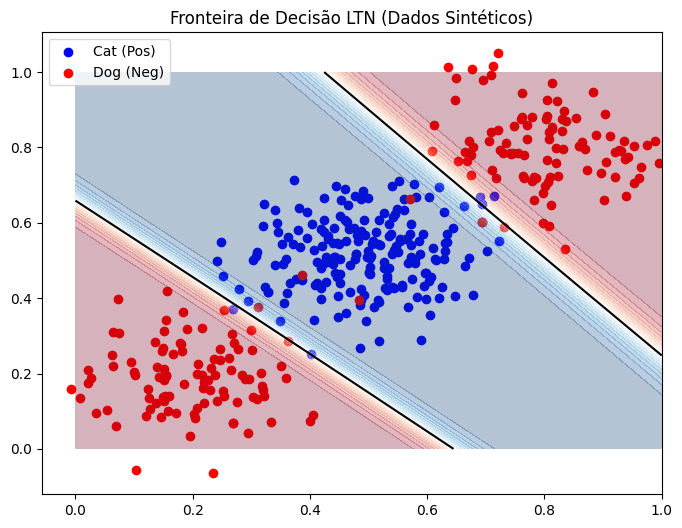

In [14]:
def generate_toy_data(n=200):
    torch.manual_seed(42)
    # Gatos: Centro (0.5, 0.5)
    pos = torch.randn(n, 2) * 0.1 + 0.5
    # Cachorros: Cantos
    neg = torch.cat([torch.randn(n//2, 2) * 0.1 + 0.2, 
                     torch.randn(n//2, 2) * 0.1 + 0.8])
    return pos.to(DEVICE), neg.to(DEVICE)

print("--- SETUP SINTÉTICO ---")
data_pos, data_neg = generate_toy_data()

# Treino
toy_model = LTNClassifier(input_dim=2, hidden_dim=32, lr=0.01, p_val=2)
toy_model.train(data_pos, data_neg, epochs=EPOCHS_SYNTHETIC, log_interval=200)

# Visualização da Fronteira de Decisão
def plot_boundary(model, pos, neg):
    plt.figure(figsize=(8, 6))
    # Dados
    plt.scatter(pos.cpu()[:,0], pos.cpu()[:,1], c='blue', label='Cat (Pos)')
    plt.scatter(neg.cpu()[:,0], neg.cpu()[:,1], c='red', label='Dog (Neg)')
    
    # Grid de decisão
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(DEVICE)
    Z = model.predict(grid).cpu().numpy().reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=20, cmap='RdBu', alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black')
    plt.title("Fronteira de Decisão LTN (Dados Sintéticos)")
    plt.legend()
    plt.show()

plot_boundary(toy_model, data_pos, data_neg)

## 5. Classificação Real (ResNet Features)
Treinamento utilizando as features extraídas do dataset Kaggle.

--- TREINAMENTO REAL ---
Treinamento iniciado (500 épocas)...
Época    0 | Loss: 0.5058 | Sat: 0.4942
Época   50 | Loss: 0.2672 | Sat: 0.7328
Época  100 | Loss: 0.0433 | Sat: 0.9567
Época  150 | Loss: 0.0114 | Sat: 0.9886
Época  200 | Loss: 0.0076 | Sat: 0.9924
Época  250 | Loss: 0.0046 | Sat: 0.9954
Época  300 | Loss: 0.0021 | Sat: 0.9979
Época  350 | Loss: 0.0013 | Sat: 0.9987
Época  400 | Loss: 0.0017 | Sat: 0.9983
Época  450 | Loss: 0.0013 | Sat: 0.9987
Época  499 | Loss: 0.0011 | Sat: 0.9989

--- RESULTADOS FINAIS ---
Acurácia Gatos: 100.00%
Acurácia Cães : 100.00%
Acurácia Total: 100.00%


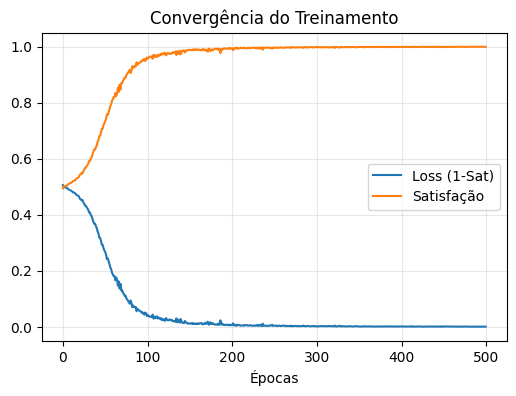

In [15]:
print("--- TREINAMENTO REAL ---")
# Instancia e treina
classifier = LTNClassifier(
    input_dim=PCA_COMPONENTS, 
    hidden_dim=HIDDEN_DIM, 
    lr=LEARNING_RATE, 
    p_val=P_VALUE
)

classifier.train(cats_final, dogs_final, epochs=EPOCHS_REAL, log_interval=50)

# Avaliação
def evaluate(model, pos, neg):
    pred_pos = model.predict(pos).cpu().numpy()
    pred_neg = model.predict(neg).cpu().numpy()
    
    acc_pos = np.mean(pred_pos > 0.5)
    acc_neg = np.mean(pred_neg <= 0.5)
    total_acc = (np.sum(pred_pos > 0.5) + np.sum(pred_neg <= 0.5)) / (len(pos) + len(neg))
    
    print("\n--- RESULTADOS FINAIS ---")
    print(f"Acurácia Gatos: {acc_pos*100:.2f}%")
    print(f"Acurácia Cães : {acc_neg*100:.2f}%")
    print(f"Acurácia Total: {total_acc*100:.2f}%")
    
    # Plot Loss
    plt.figure(figsize=(6,4))
    plt.plot(model.metrics['loss'], label='Loss (1-Sat)')
    plt.plot(model.metrics['sat'], label='Satisfação')
    plt.title("Convergência do Treinamento")
    plt.xlabel("Épocas")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

evaluate(classifier, cats_final, dogs_final)